In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import math
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from catboost import Pool, CatBoostRegressor

In [2]:
current_dir_path = os.getcwd()


In [3]:

electrode = pd.read_csv(current_dir_path + '\\datasets\\data_arc.csv')
bulk_volume = pd.read_csv(current_dir_path + '\\datasets\\data_bulk.csv')
bulk_time = pd.read_csv(current_dir_path +'\\datasets\\data_bulk_time.csv')
gas = pd.read_csv(current_dir_path +'\\datasets\\data_gas.csv')
tmpch = pd.read_csv(current_dir_path +'\\datasets\\data_temp.csv')
wire_volume = pd.read_csv(current_dir_path +'\\datasets\\data_wire.csv')
wire_time = pd.read_csv(current_dir_path +'\\datasets\\data_wire_time.csv')



## Описание данных:
- electrode - данные об электродах;
- bulk_volume - данные о сыпучих материалах (объем);
- bulk_time - данные о сыпучих материалах (время);
- gas - данные о продувку сплава газом;
- tmpch - результаты измерения температуры;
- wire_volume - данные о проволочных материалах (объем);
- wire_time - данные о проволочных материалах (время).


In [4]:
# переименуем столбец "Газ 1" в датасете gas
gas.set_axis(['key', 'gas_volume'], axis='columns', inplace=True)
# переименуем столбцы в датасете 'electrode'
electrode.set_axis(['key', 'start_heating', 'end_heating', 'real_power', 'reactive_power'],
                  axis='columns', inplace=True)

## Предобработка данных

## Проверка данных на пропуски и дубликаты

In [5]:
alldata = [electrode, bulk_volume, bulk_time, gas, tmpch, wire_volume, wire_time]
for i in alldata:
    print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   start_heating   14876 non-null  object 
 2   end_heating     14876 non-null  object 
 3   real_power      14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-n

In [6]:
bulk_volume.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [7]:
bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [8]:
wire_volume.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
tmpch.tail(10)

,key,Время замера,Температура
15897,3240,2019-09-01 03:12:19,NaN
15898,3240,2019-09-01 03:19:09,NaN
15899,3240,2019-09-01 03:31:27,NaN
15900,3240,2019-09-01 03:34:31,NaN
15901,3240,2019-09-01 03:35:16,NaN
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


In [11]:
tmpch.query('key > 2499')

,key,Время замера,Температура
12267,2500,2019-08-06 03:11:31,1539.0
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12271,2501,2019-08-06 03:44:42,1587.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


### Вывод:
1) В таблице "tmpch" в толбце "Температура" не хватает 18% данных. Это важный столбец для нас, так как мы будем брать из него один из признаков (начальная температура) и наш целевой признак (финальная температура). Если мы никак не сможем восстановить эти данные, то придется удалить строки с пропусками.

2) Кроме того, в таблице "tmpch" начиная с партии 2500 указано только одно время замера, то есть мы не сможем извлечь первое и последнее время замера температуры, а также начальную и финальную температуру для этих партий (наших будущих объектов), поэтому строки с таким дефектом придется удалить.

3) В датасетах bulk_volume и bulk_time, а также wire_volume и wire_time, содержащих информацию о сыпучих и проволочных материалах отсутствует бОльшая часть информации. В bulk_volume и bulk_time только три столбца заполнены более чем на 78%, в остальных столбцах меннее 41%; wire_volume и wire_time имеют только один столбец, заполненный на 99%, в остальных менее 35%. Необходимо выявить причину появления такого количества NaNов в 4-х таблицах и по возможности устранить проблему.

4) Столбец "key" во всех датасетах обозначает номер партии стали. Всего партий 3241. Почти во всех таблицах отсутствует небольшое количество партий, это надо иметь в виду при объединении признаков в одну таблицу.

In [12]:
print('Наличие дубликатов в данных')
for i in alldata:
    print(i.duplicated().sum())


Наличие дубликатов в данных
0
0
0
0
0
0
0


### Дубликатов не обнаружено.

## Анализ данных:

### Данные об электродах

In [13]:
electrode.head()

,key,start_heating,end_heating,real_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [14]:
electrode.describe().T

,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
real_power,14876.0,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
reactive_power,14876.0,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


{'whiskers': [<matplotlib.lines.Line2D at 0x27b7d3fe988>,
 'caps': [<matplotlib.lines.Line2D at 0x27b7d41af88>,
 'boxes': [<matplotlib.lines.Line2D at 0x27b7d3feb08>],
 'medians': [<matplotlib.lines.Line2D at 0x27b7d41a988>],
 'fliers': [<matplotlib.lines.Line2D at 0x27b7d40b048>],
 'means': []}

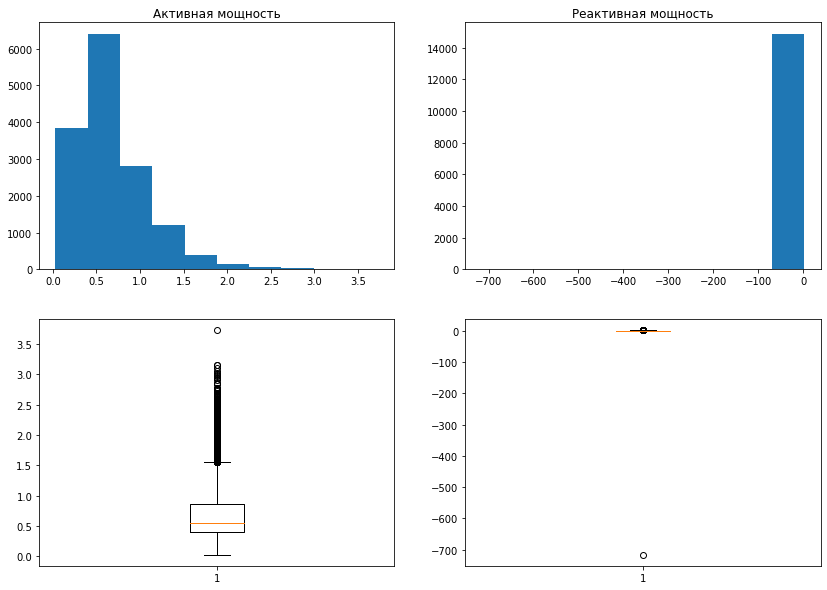

In [15]:
fig, axs = plt.subplots(2,2, figsize=(14,10))
axs[0,0].hist(electrode['real_power'])
axs[0,1].hist(electrode['reactive_power'])
axs[0,0].set_title('Активная мощность')
axs[0,1].set_title('Реактивная мощность')
axs[1,0].boxplot(electrode['real_power'])
axs[1,1].boxplot(electrode['reactive_power'])

В столбце 'reactive power' есть аномальное значение (-715), которое является минимумом столбца. Проверим, есть ли еще похожие значения.

In [16]:
electrode.query('reactive_power < -10')

,key,start_heating,end_heating,real_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Больше похожих значений нет, это скорее всего ошибка в заполнении данных, удалим строку с этим значением и посмотрим на боксплот и гистограмму еще раз, они должны стать более наглядными в отношении нормальных значений.

In [17]:
electrode = electrode.drop([9780])

In [18]:
electrode.describe().T

,count,mean,std,min,25%,50%,75%,max
key,14875.0,1615.186756,934.593897,1.000000,806.000000,1617.000000,2429.000000,3241.000000
real_power,14875.0,0.670453,0.408170,0.030002,0.395295,0.555565,0.857049,3.731596
reactive_power,14875.0,0.500723,0.310880,0.020806,0.291003,0.415984,0.637403,2.676388


Text(0.5, 1.0, 'Реактивная мощность')

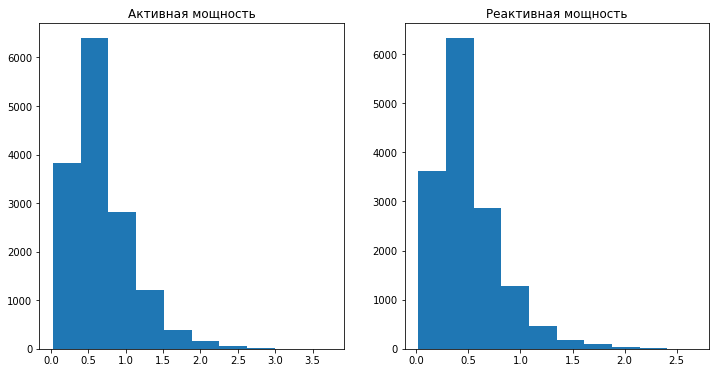

In [19]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.hist(electrode['real_power'])
ax2.hist(electrode['reactive_power'])
ax1.set_title('Активная мощность')
ax2.set_title('Реактивная мощность')

Text(0.5, 1.0, 'Реактивная мощность')

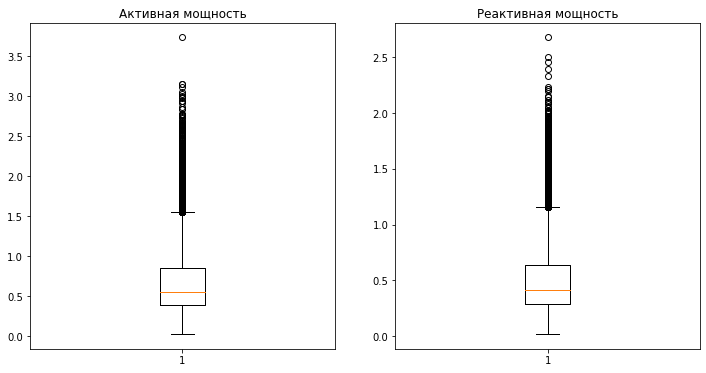

In [20]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.boxplot(electrode['real_power'])
ax2.boxplot(electrode['reactive_power'])
ax1.set_title('Активная мощность')
ax2.set_title('Реактивная мощность')

### Вывод: 
После удаления аномалии в столбце "reactive_power" данные в целом выглядят корректно, среднее увеличилось, уменьшилось стандартное отклонение, гистограмма демострирует распределение близкое к нормальному.
В столбце "real_power" изначально ничто не вызывало сомнений.

### Данные об объёме газа

               key   gas_volume
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


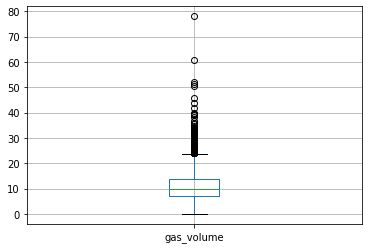

In [21]:
print(gas.describe())
gas.boxplot('gas_volume')

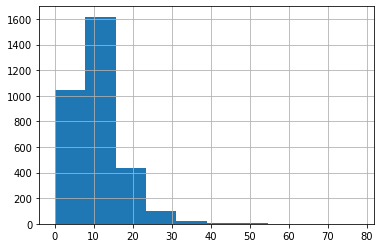

In [22]:
gas['gas_volume'].hist()

In [23]:
print(gas.query('gas_volume > 40'))

       key  gas_volume
116    117   50.581035
277    280   60.935689
319    322   77.995040
660    663   41.854643
1461  1464   43.655411
2105  2108   45.638999
2107  2110   52.142373
2567  2570   51.380229


### Вывод:
В данных по объему газа обнаружено небольшое количество выбросов. По информации "заказчика" данные значения являются естественными отклонениями в процессе обработки стали.

### Данные о температуре

                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000


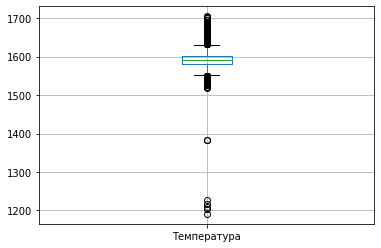

In [24]:
print(tmpch.describe())
tmpch.boxplot('Температура')

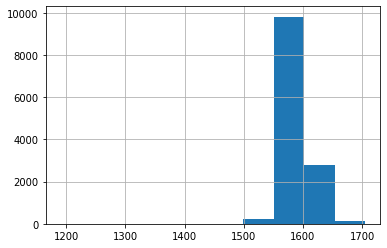

In [25]:
tmpch['Температура'].hist()#range=(1581,1601))

Данные по температуре выглядят довольно равномерными: стандартное отклонение небольшое - 21, большинство значений сосредоточены в районе 1600. Проверим, насколько существенно количество выбросов. 

In [26]:
print(tmpch.query('Температура > 1630'))
print(tmpch.query('Температура < 1550'))

        key         Время замера  Температура
189      33  2019-05-04 13:25:03       1636.0
294      51  2019-05-05 06:01:18       1660.0
295      51  2019-05-05 06:10:21       1690.0
297      52  2019-05-05 06:33:31       1652.0
298      52  2019-05-05 06:39:38       1666.0
...     ...                  ...          ...
15237  3096  2019-08-27 11:24:40       1642.0
15317  3112  2019-08-27 22:22:37       1651.0
15686  3190  2019-08-30 12:52:31       1646.0
15698  3193  2019-08-30 15:28:07       1634.0
15723  3201  2019-08-30 21:45:35       1650.0

[496 rows x 3 columns]
        key         Время замера  Температура
21        6  2019-05-03 13:49:24       1543.0
196      36  2019-05-04 14:52:00       1543.0
241      45  2019-05-04 23:06:36       1538.0
242      45  2019-05-04 23:18:03       1538.0
254      46  2019-05-04 23:55:12       1538.0
...     ...                  ...          ...
15374  3124  2019-08-28 08:22:29       1534.0
15580  3168  2019-08-29 17:56:11       1544.0
15754  320

### Вывод:
Около 500 значений находятся в районе выбросов в положительную сторону и примерно 222 - в отрицательную. Какова природа выбросов, лучше уточнить у заказчика. Тем более, что это наш целевой признак, а потбор оптимальной температуры это - это один из ключевых моментов обработки стали.


По информации "заказчика" данные значения являются естественными отклонениями в процессе обработки стали.

### Сыпучие и проволочные материалы

In [27]:
wire_volume.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [28]:
bulk_volume.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


### Вывод:
Значения объема сыпучих и проволочных материалов выглядят очень неоднородно, это может быть следствием того, что данные таблицы имеют большое количество NaN, так как заполнялись особым образом во время проведения эксперимента.

## Устранение пропущенных значений

### NaN в таблицах с данными о сыпучих и проволочных материалах.

In [29]:
# Предположим, что NaN в датасете wire_volume - это не случайные пропуски или дефект данных, а они 
# образовались из-за того, что в каких-то партиях было достаточно один или два раза добавить 
# проволочный материал, а в каких-то пришлось производить добавки до 9-ти/15-ти раз, пока не 
# достигли оптимального состава и температуры.

# Следовательно, в качестве признака для модели мы возьмем общий объём проволочного материала 
# для каждой партии
#
wire_volume.describe()
wire_volume[wire_volume['Wire 9'] > 55]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
734,782,197.542801,150.257128,NaN,NaN,NaN,NaN,NaN,NaN,55.000397
901,961,55.177196,70.122002,NaN,NaN,NaN,NaN,NaN,NaN,90.053604
947,1007,100.151993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.025600
2343,2468,135.058548,148.176082,NaN,NaN,NaN,NaN,NaN,NaN,63.044800
2345,2471,150.171829,102.182083,NaN,NaN,NaN,NaN,NaN,NaN,63.044800


### Вывод:
Итак, у нас есть 4 таблицы, похожие по количеству NaN: wire_volume, wire_time, bulk_volume, bulk_time. Значения в них распределены по всем столбцам, причем 9 столбцов (wire) и 15 столбцов (bulk) образовались в зависимости от этапа или времени добавления материала. По сути, для каждого объекта данные об объёме материала не пропущены, их только надо суммировать и мы получим признак, обозначающий общий объём сыпучих и проволочных материалов, добавленных в каждую партию.

Прежде чем получать суммы по каждой партии заменим все NaN нулями.

In [30]:
wire_volume.fillna(0, inplace=True)
wire_time.fillna(0, inplace=True)
bulk_volume.fillna(0, inplace=True)
bulk_time.fillna(0, inplace=True)

### Исследуем пропуски температуры в таблице "tmpch".

In [31]:
problem = tmpch[np.isnan(tmpch['Температура'])]
problem.head()

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN


### Вывод:
Если посмотреть не на 5 строк, а больше, можно увидеть, что пропущена не начальная, средняя или конечная температура в партии,  а мы имеем целые партии с полностью отсутствующими значениями температуры, следовательно эти партии для нас становятся бесполезными, надо удалить данные строки. Надо понимать, что таким образом мы лишимся 18% данных в общем. Но поскольку температура является нашим таргетом и одним из признаков, не желательно заполнять пропуски какими-либо значениями без проведения более глубокого исследования температур плавления стали.

In [32]:
# удалим строки с пропущенной температурой
tmpch.dropna(inplace=True)
tmpch.isnull().sum()

key             0
Время замера    0
Температура     0
dtype: int64

### Изменение типа данных в столбцах с датами и временем

In [33]:
tmpch['date'] = pd.to_datetime(tmpch['Время замера'] , format='%Y.%m.%d %H:%M:%S')
electrode['st_date'] = pd.to_datetime(electrode['start_heating'] , format='%Y.%m.%d %H:%M:%S')
electrode['end_date'] = pd.to_datetime(electrode['end_heating'] , format='%Y.%m.%d %H:%M:%S')

## Создаем таргет

In [34]:
# таблица для извлечения таргета
last_temp = tmpch.pivot_table(index='key', values='Температура', aggfunc='last')
print(last_temp)

      Температура
key              
1          1613.0
2          1602.0
3          1599.0
4          1625.0
5          1602.0
...           ...
3237       1569.0
3238       1584.0
3239       1598.0
3240       1617.0
3241       1586.0

[3216 rows x 1 columns]


## Создаем признаки

### 'time_gap' разница между первым и последним временем замера температуры

# С датами возникла какая-то проблема, надо исправить

In [40]:
first = tmpch.pivot_table(index='key', values='date', aggfunc='first')
last = tmpch.pivot_table(index='key', values='date', aggfunc='last')
first['last'] = last['date']
first.columns = ['first','last']
#first['diff'] = pd.to_datetime((first['last'] - first['first']), format='%Y.%m.%d %H:%M:%S')
first['diff'] = first['last'] - first['first']
time_gap = first['diff'].minute()
#first['time_gap'] = first['diff'].dt.minute
#first.head()


AttributeError: 'Series' object has no attribute 'minute'

### 'start_tmpch' начальная температура

In [ ]:
# таблица для извлечения начальной температуры
first_temp = tmpch.pivot_table(index='key', values='Температура', aggfunc='first')
print(first_temp)

### 'total_wire' общий объем проволочных материалов

In [ ]:
wire_volume['total'] = wire_volume['Wire 1'] +wire_volume['Wire 2'] + wire_volume['Wire 3']+ wire_volume['Wire 4']+ wire_volume['Wire 5'] +wire_volume['Wire 6']+ wire_volume['Wire 7'] +wire_volume['Wire 8']+ wire_volume['Wire 9']
wire_volume.set_index('key',inplace=True)
wire_volume.head()


In [ ]:
wire_volume.boxplot('total')
wire_volume.describe()

### 'total_bulk' общий объем сыпучих материалов

In [ ]:
bulk_volume['total_bulk'] = bulk_volume['Bulk 1'] +bulk_volume['Bulk 2'] + bulk_volume['Bulk 3']+ bulk_volume['Bulk 4']+ bulk_volume['Bulk 5'] +bulk_volume['Bulk 6']+ bulk_volume['Bulk 7'] +bulk_volume['Bulk 8']+ bulk_volume['Bulk 9'] +bulk_volume['Bulk 10'] +bulk_volume['Bulk 11'] +bulk_volume['Bulk 12'] +bulk_volume['Bulk 13'] +bulk_volume['Bulk 14'] +bulk_volume['Bulk 15']
bulk_volume.set_index('key', inplace=True)
bulk_volume.head()

In [ ]:
bulk_volume.boxplot('total_bulk')
bulk_volume.describe()

In [ ]:
bulk_volume.query('total_bulk > 1700')

Наблюдаем очень большой разброс значений, особенно в bulk_volume, стандартное отклонение 276.

### 'real_power', 'reactive_power' активная и реактивная мощность для каждой партии 
### 'real_reactive_ratio' соотношение активной и реактивной мощности 

In [ ]:
power_sum = electrode.groupby('key').sum()
power_sum['real_reactive_ratio'] = power_sum['real_power'] / power_sum['reactive_power']
print(power_sum)

In [ ]:
electrode.head(10)

### 'gross_heating_time' общее время нагрева электродами каждой партии 

In [ ]:
electrode['heating_time'] = pd.to_datetime((electrode['end_date'] - electrode['st_date']), format='%Y.%m.%d %H:%M:%S')
electrode['heating_minutes'] = electrode['heating_time'].dt.minute
electrode.head()

In [ ]:
gross_time = electrode.groupby('key').sum()
print(gross_time)


## Объединение данных

In [ ]:

all_data = gross_time.drop(['real_power',  'reactive_power'], axis=1)
all_data['start_tmpch'] = first_temp['Температура']
all_data['total_wire'] = wire_volume['total']
all_data['total_bulk'] = bulk_volume['total_bulk']
gas.set_index('key', inplace=True)
all_data['gas_volume'] = gas['gas_volume']
all_data['real_power'] = power_sum['real_power']
all_data['reactive_power'] = power_sum['reactive_power']
all_data['real_reactive_ratio'] = power_sum['real_reactive_ratio']
all_data['target'] = last_temp['Температура']
all_data['time_gap'] = first['time_gap']

In [ ]:
all_data.head()
all_data.isnull().sum()
#all_data[np.isnan(all_data['real_power_mean'])]

In [ ]:
# удалим пропуски, которые образовались во время объединения данных
all_data.dropna(inplace=True)
print(all_data.shape)

In [ ]:
# переустановим индексы
all_data.reset_index(drop=True, inplace=True)
all_data.head()

In [ ]:
# all_data['gross_heating_time'] = list(map(lambda x: math.log10(x), all_data['gross_heating_time']))
# логарифмирование значений температуры не улучшило скор

In [ ]:
all_data.head()

Удаляем строки с дефектом, который пришел из таблицы "tmpch" столбец 'Время замера'. 

In [ ]:
all_data.drop(all_data[all_data['time_gap'] == 0].index, axis=0, inplace=True)
all_data.shape

### Корреляция признаков и таргета

Прежде чем приступать к обучению моделей, еще раз посмотрим на взаимосвязь признаков с целевым признаком для того, чтобы избежать "утечек" информации.

In [ ]:
#print(len('heating_minures'))
print('Корреляция Пирсона')
print()
for i in all_data.columns:
    b = all_data[i].corr(all_data['target'])
    print('{:.<20}'.format(i), '{:.2f}'.format(b))
print()
print('Корреляция Пирсона')
print()
for i in all_data.columns:
    b = all_data[i].corr(all_data['target'], method='spearman')
    print('{:.<20}'.format(i), '{:.2f}'.format(b))

Видим, что ни один признак не демонстрирует чрезмерно сильной связи с целевым признаком (нет значений близких к 1 или -1), значит таргет не проник в признаки. С другой стороны, 'gas_volume'(объем газа) показывает очень слабую связь с целевым признаком, скорее всего он не будет оказывать влияния на результат обучения модели, его надо удалить.

### Разделение данных на тренировочную, валидационную и тестовую выборку

In [ ]:
df_train, df_part = train_test_split(all_data, test_size=0.4, random_state=12345)
df_valid, df_test = train_test_split(df_part, test_size=0.5, random_state=12345) 
print(df_train.shape, df_valid.shape, df_test.shape)

In [ ]:
# разделяем признаки и таргет
train_target = df_train['target']
train_features = df_train.drop('target', axis=1)
valid_target = df_valid['target']
valid_features = df_valid.drop('target', axis=1)
test_target = df_test['target']
test_features = df_test.drop('target', axis=1)

## Обучение моделей

### Линейная регрессия

In [ ]:
lr_model = LinearRegression()
lr_model.fit(train_features, train_target)
lr_pred = lr_model.predict(train_features)
lr_mae = mean_absolute_error(train_target, lr_pred)
print(lr_mae)

In [ ]:
lr_valid_pred = lr_model.predict(valid_features)
print(mean_absolute_error(valid_target, lr_valid_pred))

### Случайный лес

In [ ]:
rf = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=12345)
rf.fit(train_features,train_target)
rf_pred = rf.predict(train_features)
rf_mae = mean_absolute_error(train_target, rf_pred)
print(rf_mae)

In [ ]:
valid_pred = rf.predict(valid_features)
print(mean_absolute_error(valid_target, valid_pred))

### Градиентный бустинг


In [ ]:
cb_model = CatBoostRegressor(learning_rate=0.01)
cb_model.fit(train_features, train_target)

In [ ]:
train_pred_cb = cb_model.predict(train_features)
cb_mae = mean_absolute_error(train_target, train_pred_cb)
print('MAE Градиентный бустинг')
print('Тренировочная выборка')
print(cb_mae.round(2))

In [ ]:
valid_pred_cb = cb_model.predict(valid_features)
cb_valid_mae = mean_absolute_error(valid_target, valid_pred_cb)
print('MAE Градиентный бустинг')
print('Валидационная выборка')
print(cb_valid_mae.round(2))

In [ ]:
test_pred = cb_model.predict(test_features)
test_mae = mean_absolute_error(test_target, test_pred)
print('МАЕ Градиентный бустинг')
print('Тестовая выборка')
print(test_mae.round(2))